In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime


from ngram import *
from baselines import *
from error_analysis import *
pd.options.mode.chained_assignment = None


### Load Annotated Data

In [2]:
task = 'recipient'
xtype = 'comments'
ytype = 'plurality'
n_classes = 2

time: 1.85 ms


In [3]:
data = load_comments_and_labels(task)

time: 1min 52s


In [4]:
X_train, y_train = assemble_data(data, xtype, ytype, splits = ['train'])
X_test, y_test = assemble_data(data, xtype, 'empirical_dist', splits = ['test'])

time: 27 ms


### Hyper-Parameter tuning

In [5]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(solver = 'sag')),
])

time: 1.43 ms


In [6]:
param_grid = {
    'vect__max_features': (500, 5000, 10000, 50000, None), 
    'vect__ngram_range': ((1,5),),  
    'vect__analyzer' : ('char',), 
}

tune (X_train, y_train, cv_pipeline, param_grid, roc_scorer, n_jobs=8, verbose=True)


Best parameters set found:
{'vect__ngram_range': (1, 5), 'vect__max_features': None, 'vect__analyzer': 'char'} 0.970897827253


Grid scores:
0.94830 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__max_features': 500, 'vect__analyzer': 'char'}
0.96665 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__max_features': 5000, 'vect__analyzer': 'char'}
0.96849 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__max_features': 10000, 'vect__analyzer': 'char'}
0.97040 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__max_features': 50000, 'vect__analyzer': 'char'}
0.97090 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__max_features': None, 'vect__analyzer': 'char'}
time: 3min 13s


### Eval Best Pipeline

In [7]:
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = 50000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 5.0,  solver = 'sag')),
])

time: 24.8 ms


In [8]:
model = optimal_pipeline.fit(X_train, y_train)
roc_df, spearman_df = test_cross(model, data, xtype)

time: 4min 6s


In [9]:
roc_df

,random,blocked,both
user,0.986265,0.955704,0.966432
article,0.984817,0.970908,0.978492
both,0.984241,0.966018,0.975008


time: 14.9 ms


In [10]:
spearman_df

,random,blocked,both
user,0.262370,0.666588,0.626791
article,0.213721,0.465160,0.404007
both,0.258086,0.638492,0.580485


time: 7.13 ms


### Does Adding Blocked Data Help predicting on Random Data?

#### User

In [11]:
train_params = [
                {'nss': ['user'],
                 'samples': ['random']},
                {'nss': ['user'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['user'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.953
	Spearman: 0.128

Train:  {'samples': ['random', 'blocked'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.985
	Spearman: 0.241
time: 1min 38s


#### Article

In [12]:
data['user']['random']['dev']['x']['comments'].shape

(3638,)

time: 2.23 ms


In [13]:
train_params = [
                {'nss': ['article'],
                 'samples': ['random']},
                {'nss': ['article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['article'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)

/Users/ellerywulczyn/miniconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Train:  {'samples': ['random'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.987
	Spearman: 0.173

Train:  {'samples': ['random', 'blocked'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.987
	Spearman: 0.230
time: 1min 43s


## Does adding random and blocked data from one namespace help predict on random data from the other namespace?

#### User

In [14]:
train_params = [
                {'nss': ['user'],
                 'samples': ['random', 'blocked']},
                {'nss': ['user', 'article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['user'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random', 'blocked'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.985
	Spearman: 0.241

Train:  {'samples': ['random', 'blocked'], 'nss': ['user', 'article']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.986
	Spearman: 0.262
time: 3min 12s


#### Article

In [15]:
train_params = [
                {'nss': ['article'],
                 'samples': ['random', 'blocked']},
                {'nss': ['user', 'article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['article'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random', 'blocked'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.987
	Spearman: 0.230

Train:  {'samples': ['random', 'blocked'], 'nss': ['user', 'article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.985
	Spearman: 0.214
time: 3min 9s


### Check Calibration

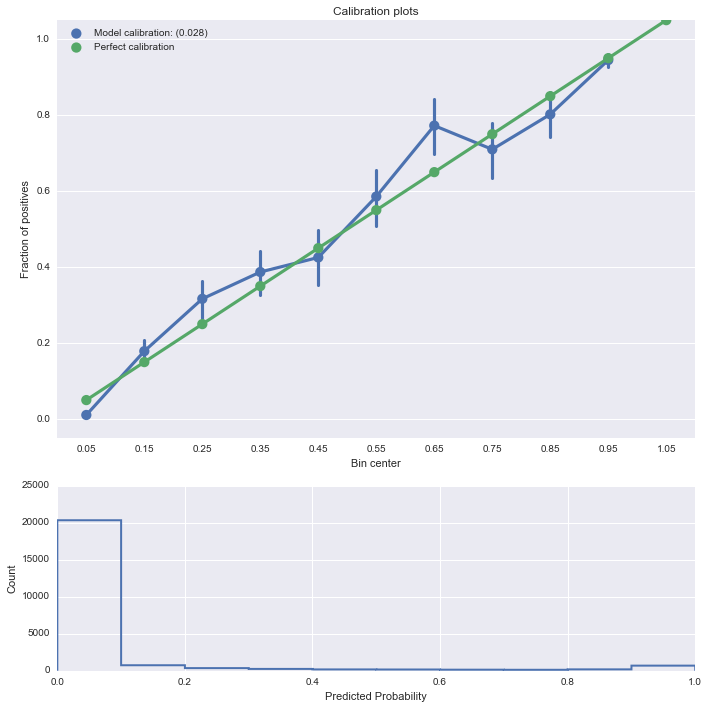

time: 30.4 s


In [16]:
y_test_oh = one_hot(y_test)
y_pred_ed = model.predict_proba(X_test)

if n_classes > 2:
    classes = range(n_classes)
else:
    classes = [1]

for i in classes:
    plt.figure()
    calibration_curve_plotter(y_test_oh[:, i], y_pred_ed[:, i])
    plt.show()

### Error Analysis

In [17]:
for i in classes:
    print('\n\n\nCLASS: ', i)
    over, under = get_errors(X_test, y_test_oh[:, i], y_pred_ed[:, i])
    print('\n\nOVER\n')
    print_errors(over, n=10)
    print('\n\nUNDER\n')
    print_errors(under, n=10)




CLASS:  1


OVER

COMMENT:
 you a bitch I hope you die you﻿ worthless pathetic fucking cunt.
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
 She is a Motherfucker I will block you Motherfucker, Shit, bitch, punch, kill, swear, do nudity, so shut up, frickin around give you drugs, call you names like shit, fuck, bum, poo, damn! so fucker, you will be blocked and dead you shit and fuck, and I will do the rude finger sign. You fucker get bad new messages bum, oh shit.
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
 i dont lambs12 wikipedia sucks ass pussy in the dick i dont give a pussy fuck about lambs12 bitch nigger asshole cock  retyc
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
 hi if you know clown will kill me guy then tell him that he is stupid, ugly, fat, gay, his mother's a whore, he smells like shit, he's an asshole, a bastard, and his little name just might be the gayest fucking thing i have ever heard. Hey and you a

### Learning Curves!
How does adding more training data improve performance?

In [18]:
#ms, metrics = eval_adding_other_data(optimal_pipeline, None, None, X_test, y_test, X_train, y_train, roc_scorer)
#plot_adding_other_data(ms, metrics)

time: 831 µs


### Model Understanding

In [19]:
feature_names = np.array(model.named_steps['vect'].get_feature_names())
for i in classes:
    print('\n\nCLASS: ', i)
    
    try:
        coef = model.named_steps['clf'].coef_[i].ravel()
    except:
        coef = model.named_steps['clf'].coef_.ravel()
    most_pos_idx = np.argsort(coef)[-100:]
    most_pos = feature_names[most_pos_idx]
    print('STRONG POS: ')
    print(most_pos)
    most_neg_idx = np.argsort(coef)[:100]
    most_neg = feature_names[most_neg_idx]
    print('STRONG NEG: ')
    print(most_neg)



CLASS:  1
STRONG POS: 
['ass.' ' kil' 'suck ' 'cum' 'bag' ' shi' 'itc' 'sh' ' cunt' 'u suc' 'kil'
 'pid' 'u a' 'u fuc' 'gay' ' f' ' fag' 'get a' 'oro' 'uck ' 'dick' 'ur '
 'ou fu' 'dumb' 'ose' 'cr' ' fuck' 'tup' 'u.' ' shit' 'are a' ' gay' 'upid'
 'u fu' 'suck' 'your' 'stup' 'tupid' 'itch' ' fu' 'stupi' 'tupi' 'shi'
 '? g' 'ck ' 'tard' ' ur ' 'shut' 'hut' 'oser' 'f*' 'fag' 'dio' ' f*'
 'oron' '*' 'k off' '!' 'moro' ' ur' 'fu' ' idio' ' fuc' 'you ' 'shit'
 'e a ' 'ou ' 'idiot' 'idio' ' idi' ' moro' 'moron' 'ass' 'go ' 'uc'
 'uck y' 'bitc' ' die' 'ck yo' ' bitc' 'die' 'bitch' ' ass' ' yo' 'ck y'
 ' you' ' ass ' 're a ' 'iot' 'idi' ' y' 'diot' 'fuck' 'ck' 'uck' 'fuc'
 'u ' ' u ' 'yo' 'you']
STRONG NEG: 
[' ' 'is a' '?' 'is a ' '"' 'e' 's a ' 'm a' 'hank ' 's fuc' 's a f' 'they'
 ' he ' 'ank ' 'is ' 'am a' ' is a' 's fu' ')' 'they ' 'ank y' 'ur se'
 'nk yo' 'n' 'ion' 's a' 'm a ' 've yo' 'gre' 'nk y' 'is' 'hank' 'gy'
 'thank' 'g bit' 'on' ' they' 'it of' ':' 'is fu' 'k b' 'am a ' 'r u' '

### Final Model

In [20]:
X, y = assemble_data(data, xtype, ytype)
final_model = optimal_pipeline.fit(X, y)
joblib.dump(final_model, '../../models/%s_ngram.pkl' % task)

['../../models/recipient_ngram.pkl',
 '../../models/recipient_ngram.pkl_01.npy',
 '../../models/recipient_ngram.pkl_02.npy',
 '../../models/recipient_ngram.pkl_03.npy',
 '../../models/recipient_ngram.pkl_04.npy',
 '../../models/recipient_ngram.pkl_05.npy',
 '../../models/recipient_ngram.pkl_06.npy']

time: 3min 19s
